# Valuación de opciones con barrera

## 1. Recorderis de valuación usando simulación...

In [1]:
#importar los paquetes que se van a usar
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.neighbors import KernelDensity
import datetime
from datetime import datetime, timedelta
import scipy.stats as st
import scipy as sp
import scipy.optimize as optimize
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#algunas opciones para Python
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 78)
# pd.set_option('precision', 3)

In [3]:
# Sobre escribir el paquete de yahoo finance a pandas datareader
import yfinance as yf
yf.pdr_override()

# Función para descargar precios de cierre ajustados:
def get_adj_closes(tickers, start_date=None, end_date=None):
    # Fecha inicio por defecto (start_date='2010-01-01') y fecha fin por defecto (end_date=today)
    # Descargamos DataFrame con todos los datos
    closes = web.get_data_yahoo(tickers, start=start_date, end=end_date)
    # Solo necesitamos los precios ajustados en el cierre
    closes = closes['Adj Close']
    # Si la cantidad de activos fue pasado cómo string entonces convertir el resultado a DataFrame
    if isinstance(tickers, str):
        closes = closes.to_frame(tickers)
    elif len(tickers) == 1:
        closes = closes.to_frame(tickers[0])
        
    # Se ordenan los índices de manera ascendente
    closes.sort_index(inplace=True)
    return closes

####### Calculation of log-returns
def calc_daily_ret(closes):
    return np.log(closes/closes.shift(1)).dropna()

In [4]:
closes = get_adj_closes(['AAPL'], '2017-01-01')
closes_appl = closes.loc[:,'AAPL']
closes_appl

[*********************100%***********************]  1 of 1 completed


Date
2017-01-03     27.023705
2017-01-04     26.993456
2017-01-05     27.130728
2017-01-06     27.433191
2017-01-09     27.684460
                 ...    
2023-11-16    189.710007
2023-11-17    189.690002
2023-11-20    191.449997
2023-11-21    190.639999
2023-11-22    191.309998
Name: AAPL, Length: 1735, dtype: float64

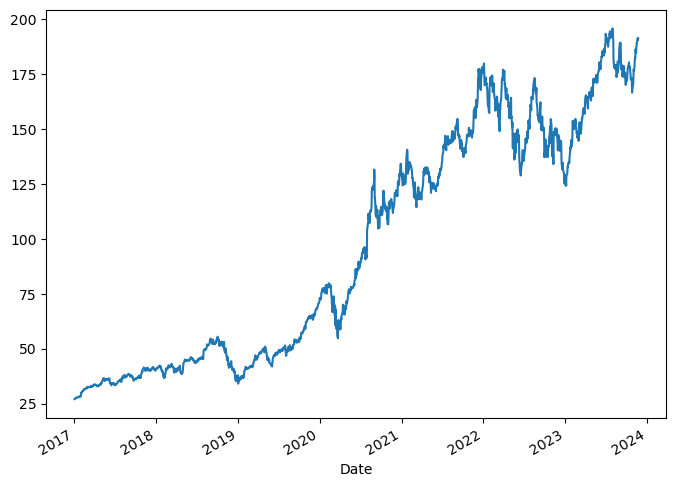

In [5]:
closes_appl.plot(figsize=(8,6));

In [6]:
closes_appl[-1]

191.30999755859375

## Calculamos rendimientos

In [7]:
ret_appl = calc_daily_ret(closes_appl)

## Descargamos datos de opciones para poder valuarlos (sino es posible descargar datos de opciones ir y contrastar con datos directamente de la página de yahoo finance)


Descargamos datos de opciones de Apple

In [8]:
def get_options_data(ticker: "Ticker en formato string", download_data=False, fecha=None):
    """
    options_yf descarga información de opciones financieras con ayuda de yfinance

    *ticker : es el símbolo de cotización de la acción
    """
    stock = yf.Ticker(ticker)
    
    if fecha is None:
        fecha = stock.options[0]
        print(f'Fechas de cierre de contrato para las opciones: \n {stock.options}')
    
    if download_data:
        print(f'Se está descargando datos de call y put de la fecha {fecha}')
        calls, puts = stock.option_chain(fecha) 
        return (calls, puts)

ticker = 'AAPL'

get_options_data(ticker, download_data=False)

Fechas de cierre de contrato para las opciones: 
 ('2023-11-24', '2023-12-01', '2023-12-08', '2023-12-15', '2023-12-22', '2023-12-29', '2024-01-19', '2024-02-16', '2024-03-15', '2024-04-19', '2024-06-21', '2024-07-19', '2024-09-20', '2024-12-20', '2025-01-17', '2025-06-20', '2025-09-19', '2025-12-19', '2026-01-16')


Opción que deseamos valuar

In [9]:
expiry_date = '2024-12-20'
calls, puts = get_options_data(ticker, download_data=True, fecha=expiry_date)

Se está descargando datos de call y put de la fecha 2024-12-20


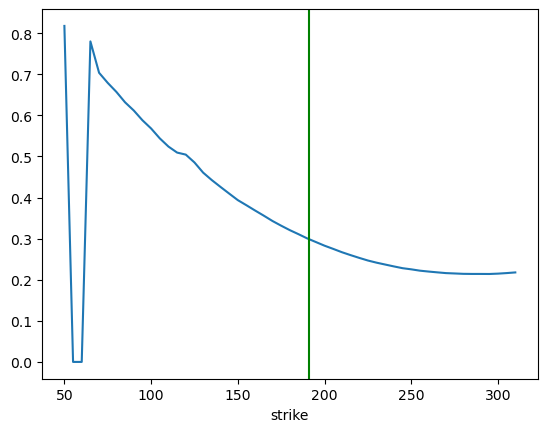

In [10]:
ax = calls.set_index('strike')['impliedVolatility'].plot()
ax.axvline(closes_appl.iloc[-1], color='g');

Información de la opción

In [22]:
K = 150
opt_valuar = calls[calls['strike'] == K]
opt_valuar

,contractSymbol,lastTradeDate,strike,lastPrice,bid,...,openInterest,impliedVolatility,inTheMoney,contractSize,currency
20,AAPL241220C00150000,2023-11-21 16:41:14+00:00,150.0,51.5,52.7,...,198,0.393713,True,REGULAR,USD


# Simulación de precios

### 1.1 Modelo normal de rendimientos

> https://www.treasury.gov/resource-center/data-chart-center/interest-rates/Pages/TextView.aspx?data=yield

### ¿Qué sucede cuando el tiempo de cierre de mi contrato no es a un año?

En la fórmula de Black-Scholes, la tasa libre de riesgo utilizada se refiere a la tasa de interés libre de riesgo anualizada. Esto se debe a que el modelo supone que los precios del subyacente y la volatilidad del mismo son constantes durante el período de tiempo hasta la expiración de la opción, y utiliza la tasa de interés libre de riesgo para descontar el valor futuro de la opción al valor presente.

Sin embargo, si el parámetro `T` (fecha de cierre de mi contrato) representa un período de tiempo diferente a un año, entonces es necesario ajustar la tasa libre de riesgo para reflejar el período de tiempo en cuestión. Por ejemplo, si `T` representa 156 días, entonces la tasa libre de riesgo utilizada en la fórmula de Black-Scholes debe ser la tasa libre de riesgo anualizada equivalente para ese período de tiempo. Esto se puede calcular utilizando la siguiente fórmula:

$$
r_t = (1 + r_a)^{(t/365)} - 1
$$
Donde $r_t$ es la tasa libre de riesgo para el período de tiempo $t$ (expresado en días), $r_a$ es la tasa libre de riesgo anualizada y 365 es el número de días en un año.

Con esta información, vamos a calcular los datos en base a la fecha de cierre de mi contrato pactada.

In [12]:
# Desviación estándar de los rendimientos diaria
sigma_diaria = ret_appl.std()

# Desviación estándar de los rendimientos diaria anualizada
sigma_a = sigma_diaria * np.sqrt(252)

# Tasa libre de riesgo anualizada
r_a = 0.0526

In [13]:
expiry_date

'2024-12-20'

## Tasa de dividendos
**La tasa de dividendos es la cantidad de dinero que una empresa paga a sus accionistas en forma de dividendos**. Los dividendos son una forma de distribución de las ganancias de una empresa a sus accionistas y pueden ser pagados en efectivo, en acciones adicionales o en alguna otra forma de valor.

La tasa de dividendos se expresa como un porcentaje del precio de la acción y se calcula dividiendo el dividendo anual por la cotización actual de la acción. Por ejemplo, si una empresa paga un dividendo anual de $\$$2 por acción y la cotización actual de la acción es de $\$$100, la tasa de dividendos es del 2% $(\$2/\$100)$.

En la valoración de opciones sobre acciones, **la tasa de dividendos es importante porque afecta el valor de la opción**. Como mencioné anteriormente, el propietario de la opción tiene derecho a recibir cualquier dividendo que se pague durante el período hasta la expiración de la opción. Por lo tanto, si una empresa paga un dividendo, el valor de la opción se reduce debido a que se espera que el precio de la acción se reduzca después del pago del dividendo. En general, una tasa de dividendos más alta conduce a una reducción del valor de la opción.

## Donde se puede encontrar esta información
Pueden encontrar la tasa de dividendos de una empresa en Yahoo Finance de la siguiente manera:
1. Busca el ticker de la empresa que te interesa.
2. Haz clic en el ticker para acceder a la página de resumen de la empresa.
3. Haz clic en la pestaña "Estadísticas" en la parte superior de la página.
4. Desplázate hacia abajo hasta la sección "Rendimiento de dividendos" para ver la tasa de dividendos actual de la empresa. Si deseas ver el historial de dividendos de la empresa, puedes hacer clic en "Historial de dividendos" debajo de la sección "Rendimiento de dividendos".

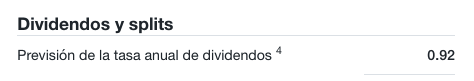

https://es.finance.yahoo.com/quote/AAPL/key-statistics?p=AAPL

## Usar los datos de la opción a valuar

In [14]:
from datetime import date

# Datos de la opción y del día actual
today = pd.Timestamp(date.today())
expiry = expiry_date

dates = pd.date_range(start=today, end=expiry, freq='B')

NbTraj = 10000

# Tiempo de cierre de contrato en años
T = len(dates) / 365

# Pasos de tiempo
NbStep = 100

# Precio inicial del activo subyacente
S0 = closes_appl.iloc[-1]

# Tasa libre de riesgo anualizada en función de la cantidad de días 
# de cierre del contrato
r = (1 + r_a)**(len(dates) / 365) - 1

# Tasa anual de dividendos (yahoo finance)
q = 0.0096

# Volatilidad del activo subyacente anualizada
sigma = sigma_a

# Strike price
K = K   

### Simulación de precios

In [15]:
def BSprices(mu, sigma, q, S0, NbTraj, NbStep, T):
    """
    Expresión de la solución de la ecuación de Black-Scholes
    St = S0*exp((r-sigma^2/2)*t+ sigma*DeltaW)
    
    Parámetros
    ---------
    mu    : Tasa libre de riesgo anualizada
    sigma : Desviación estándar de los rendimientos anualizada
    q     : tasa de dividendo anual
    S0    : Precio inicial del activo subyacente
    NbTraj: Cantidad de trayectorias a simular
    NbStep: Número de días a simular
    T     : Tiempo de cierre de la opción anualizada
    """
    # Datos para la fórmula de St
    nu = mu - q - (sigma**2)/2
    DeltaT = T/NbStep
    SqDeltaT = np.sqrt(DeltaT)
    DeltaW = SqDeltaT*np.random.randn(NbTraj,NbStep-1)
    
    # Se obtiene --> Ln St = Ln S0+ nu*DeltaT + sigma*DeltaW
    increments = nu*DeltaT + sigma*DeltaW
    concat = np.concatenate((np.log(S0)*np.ones([NbTraj,1]),increments),axis=1)
    
    # Se utiliza cumsum por que se quiere simular los precios iniciando desde S0
    LogSt = np.cumsum(concat,axis=1)
    # Se obtienen los precios simulados para los NbStep fijados
    St = np.exp(LogSt)
    # Vector con la cantidad de días simulados
    t = np.arange(0,NbStep)
    
    prices = pd.DataFrame(St.T, index=t)

    return prices

def calc_daily_ret(closes):
    return np.log(closes/closes.shift(1)).iloc[1:]

In [16]:
# Resolvemos la ecuación de black scholes para obtener los precios
prices = BSprices(r, sigma, q, S0, NbTraj, NbStep, T)

prices

,0,1,2,3,4,...,9995,9996,9997,9998,9999
0,191.309998,191.309998,191.309998,191.309998,191.309998,...,191.309998,191.309998,191.309998,191.309998,191.309998
1,186.660179,192.067918,193.706554,190.554342,185.083224,...,182.226606,189.334901,189.725855,197.108505,191.664682
2,184.808381,194.984930,197.532366,190.759758,184.392229,...,178.725414,195.423752,201.686639,198.117851,191.357349
3,188.053736,191.621895,198.322308,195.307539,182.490453,...,177.292573,191.105166,198.659210,195.592536,191.010610
4,194.111776,187.600789,200.493105,192.704037,176.476725,...,169.760042,195.539308,199.765208,187.475563,197.599028
...,...,...,...,...,...,...,...,...,...,...,...
95,156.345965,232.044669,133.698014,143.414789,261.132985,...,96.168122,145.278948,268.493141,267.765852,292.432961
96,159.491029,231.648651,132.090427,152.027828,261.588197,...,99.014004,142.606719,261.037462,258.448227,293.227590
97,162.994013,231.107023,129.435067,152.420684,252.838967,...,96.913937,143.447795,277.801591,252.081746,299.498949
98,161.432719,232.888419,127.191248,152.124232,251.579198,...,93.387895,139.132291,276.888243,253.553522,300.756888


<Axes: >

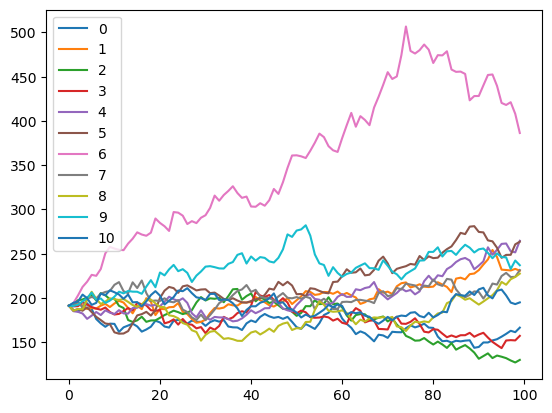

In [17]:
prices.loc[:, :10].plot()

## Valuar la opción Europea usando montecarlo

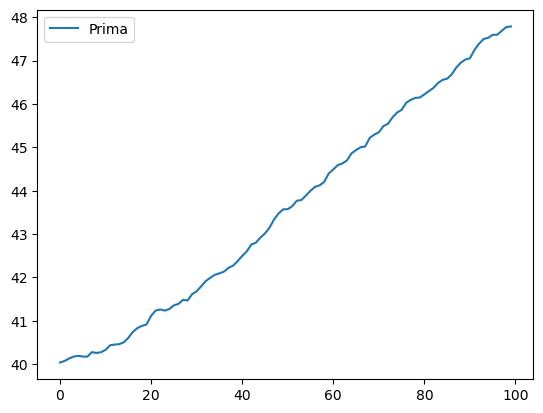

In [18]:
call_europea = pd.DataFrame({'Prima':np.exp(-r*T)*np.fmax(prices - K, 0).mean(axis=1)})
call_europea.plot();

Intervalo de confianza del 99%

In [19]:
confianza = 0.99
sigma_est = prices.iloc[-1].sem()
mean_est = call_europea.iloc[-1].Prima
i1 = st.t.interval(confianza, NbTraj - 1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i1)
print(i2)


(46.44885043274025, 49.12308370321799)
(46.4491056740907, 49.12282846186754)


In [20]:
opt_valuar

,contractSymbol,lastTradeDate,strike,lastPrice,bid,...,openInterest,impliedVolatility,inTheMoney,contractSize,currency
20,AAPL241220C00150000,2023-11-21 16:41:14+00:00,150.0,51.5,52.7,...,198,0.393713,True,REGULAR,USD


#### Yahoo-Finance (https://finance.yahoo.com/)

## 2. Aspectos teóricos opciones barrera

Para un activo con precio $S_t$, se considera una opción de la siguiente forma
\begin{equation}
    V_T=u(t)F_T
\end{equation}
para $0\leq t\leq T$. En este caso, $F_T=\max(S_T-K,0)$ para una opción tipo call o $F_T=\max(K-S_T,0)$ para una opción tipo put. La función $u(t)$ está definida en $0\leq t\leq T$, toma el valor de uno sí se cumple cierta condición y el valor de cero en otra caso. 

Por otro lado, para $B>0$ y $0<t<T$ se dice que $S_t$ ha superado la barrera $B$ sí $S_0<B$ y $S_t>B$ para algún tiempo $t$ en el periodo considerado. Similarmente, se dice que $S_t$ ha caído por debajo de la barrera $B$ sí $S_0>B$ y $S_t<B$ para algún tiempo $t$ en el periodo considerado.

Finalmente, para un enunciado $x$, se define la función indicadora $I(x)$ como $I(x)=1$ si $x$ se cumple e $I(x)=0$ en otro caso.

Se esta forma, pueden definirse las siguientes acciones

* Up-and-out: Sí $S_0<B$, entonces $u(t)=I(S_t<B)$.
* Down-and-out: Sí $S_0>B$, entonces $u(t)=I(S_t>B)$.
* Up-and-in: Sí $S_0<B$, entonces $u(t)=I(S_t>B)$.
* Down-and-in: Sí $S_0>B$, entonces $u(t)=I(S_t<B)$.

Así se se pueden definirse ocho nuevos tipos de opciones. 

* Up-and-out call: Sí $S_0<B$, $C_t^{uo}=\max\{S_T-K,0\}I(S_t<B)$
* Down-and-out call: Sí $S_0>B$, $C_t^{do}=\max\{S_T-K,0\}I(S_t>B)$
* Up-and-in call: Sí $S_0<B$, $C_t^{ui}=\max\{S_T-K,0\}I(S_t>B)$
* Down-and-in call: Sí $S_0>B$, $C_t^{di}=\max\{S_T-K,0\}I(S_t<B)$
* Up-and-out put: Sí $S_0<B$, $P_t^{uo}=\max\{K-S_T,0\}I(S_t<B)$
* Down-and-out put: Sí $S_0>B$, $P_t^{do}=\max\{K-S_T,0\}I(S_t>B)$
* Up-and-in put: Sí $S_0<B$, $P_t^{ui}=\max\{K-S_T,0\}I(S_t>B)$
* Down-and-in put: Sí $S_0>B$, $P_t^{di}=\max\{K-S_T,0\}I(S_t<B)$


A las del tipo *up-and-out* y *down-and-out* se les conoce como opciones *knock-out*. De la misma forma, a las del tipo *up-and-in* y *down-and-in* se les conoce como opciones *knock-in*.

Note que estas son **opciones dependientes de la trayectoria del precio**, dado que $u(t)$ depende de $S_t$.

> Son opciones para aquellos inversores que tengan unas expectativas muy claras sobre la dirección, ascendente o descendente, del precio del subyacente, y apuesten fuertemente por ello. 

## 2.1 Knock-out
Si el precio spot toca la barrera antes del vencimiento, las opciones se desactivan.

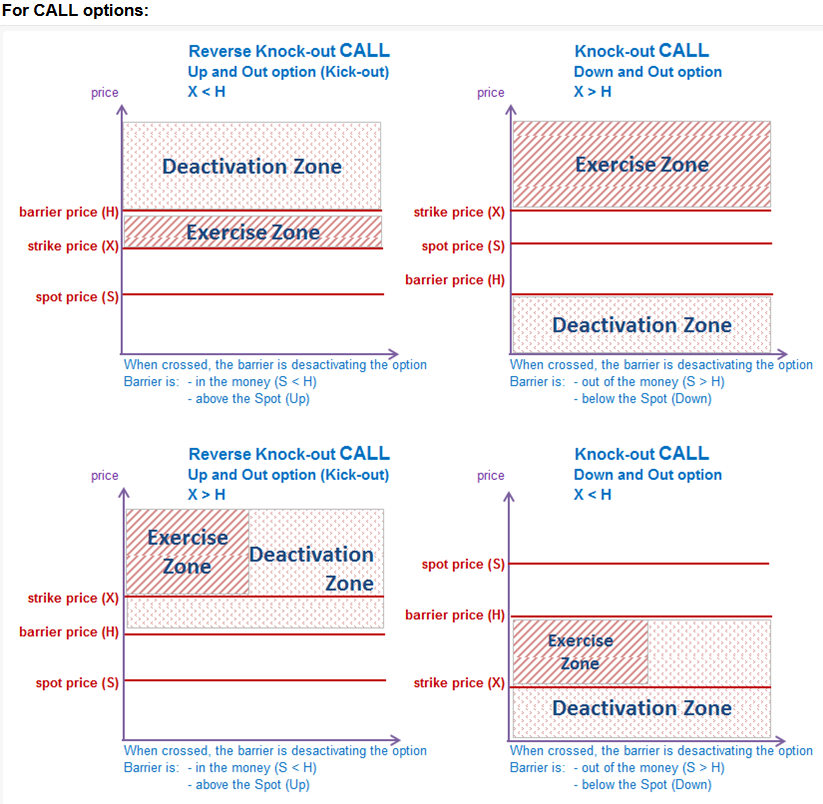

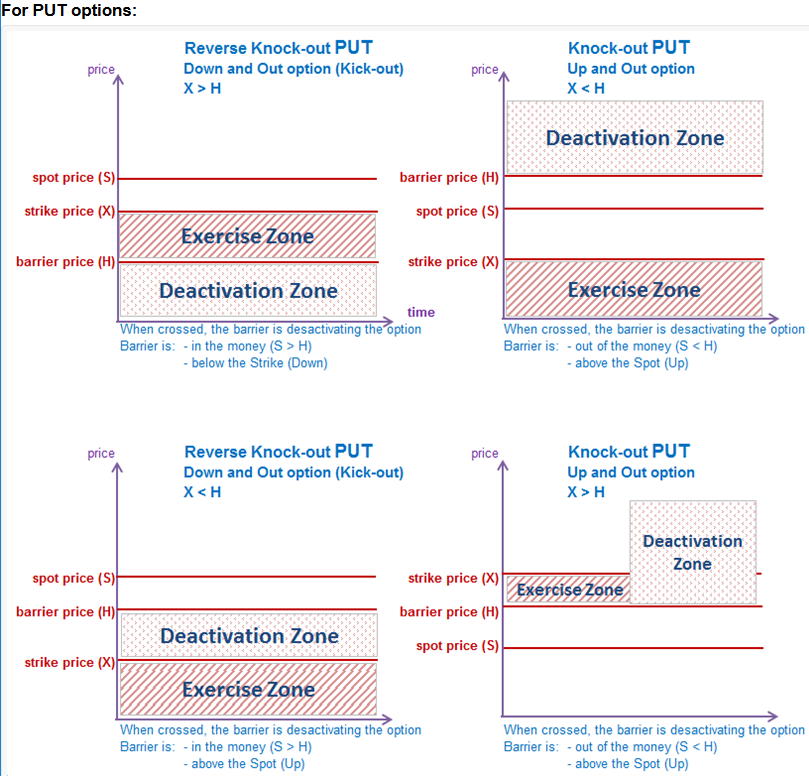

## 2.2 Knock-in

Una vez que el precio spot toca la barrera antes de su vencimiento, las opciones se activan.

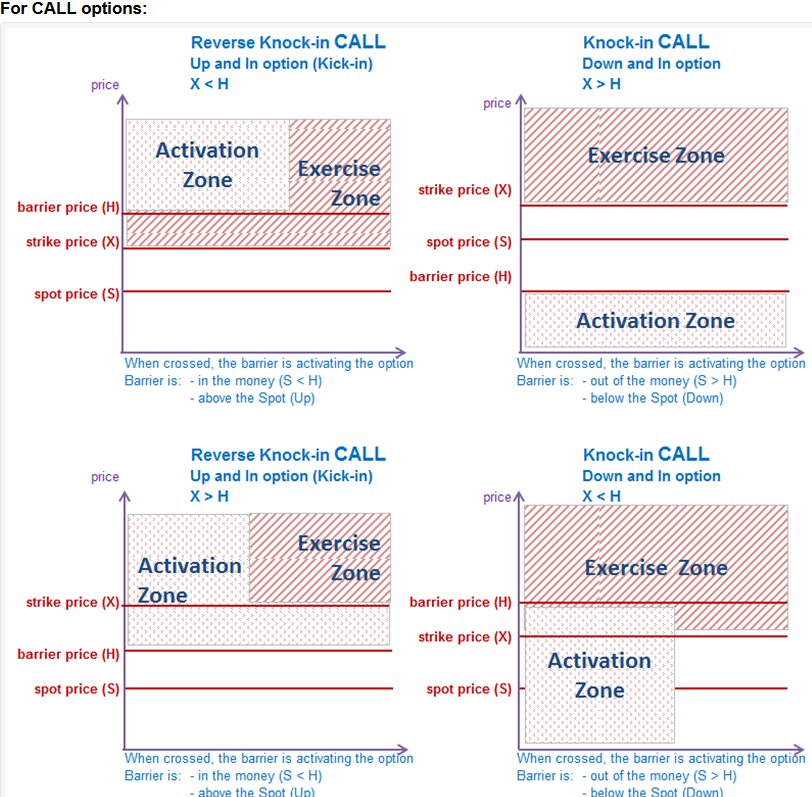

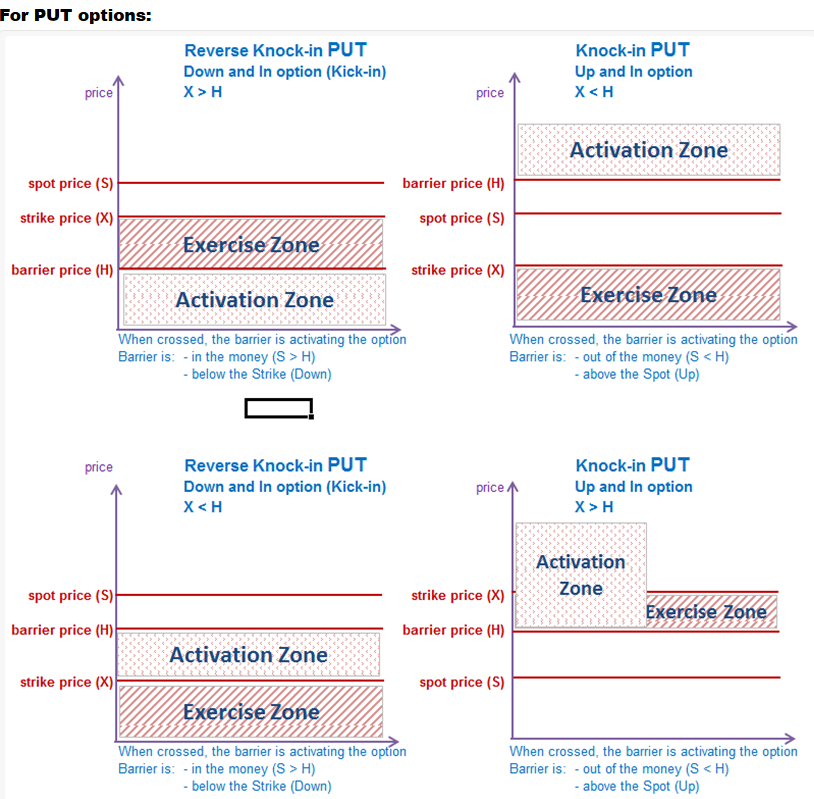

## 3. Valuación de una opción up and in

### 3.1 Modelo normal de rendimientos

In [23]:
# Resolvemos la ecuación de black scholes para obtener los precios con los datos anteriores
sim_closes = BSprices(r, sigma, q, S0, NbTraj, NbStep, T)

sim_closes

,0,1,2,3,4,...,9995,9996,9997,9998,9999
0,191.309998,191.309998,191.309998,191.309998,191.309998,...,191.309998,191.309998,191.309998,191.309998,191.309998
1,191.748589,185.495550,188.727657,197.545088,192.853901,...,192.599544,187.640525,181.182136,186.233727,198.868574
2,191.851337,180.854264,189.655674,206.540505,189.130018,...,192.824633,184.414603,186.965580,188.099364,204.742705
3,182.533648,170.180882,186.747039,216.908448,183.851560,...,197.150796,178.842774,189.411369,196.176061,194.207370
4,180.923294,166.159597,185.783778,221.237086,183.096425,...,202.314185,174.516920,188.508287,190.754509,199.721435
...,...,...,...,...,...,...,...,...,...,...,...
95,197.496873,145.822936,132.477409,144.585574,374.893394,...,161.772983,201.290664,215.024227,165.353594,173.773822
96,194.041707,138.681833,130.914916,140.527260,379.569377,...,166.379278,203.525712,212.392237,169.822915,168.094971
97,199.679728,138.808817,127.881024,137.947153,389.000729,...,164.479259,204.715984,219.385533,169.659245,165.239533
98,196.468420,135.818636,128.467554,136.030648,376.117015,...,165.050025,207.426779,219.832698,162.754167,157.691816


Hasta la simulación, todo normal... falta crear la función indicadora

In [25]:
True + True

2

In [27]:
pd.set_option('display.max_columns', 15)

# Precio barrera
B = 140    

# Función de activación (knock-in)
# Si en algún momento el precio toca la barrera la opción se activa
I = (sim_closes > B).cumsum(axis=0) > 0
I

,0,1,2,3,4,5,6,...,9993,9994,9995,9996,9997,9998,9999
0,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True
1,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True
2,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True
3,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True
4,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True
96,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True
97,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True
98,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True


In [31]:
pd.set_option('display.max_columns', 35)

# Función de desactivación (knock-out)
# Si en algún momento el precio toca la barrera la opción se desactiva
I = (sim_closes < B).cumprod(axis=0) > 0
I

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,...,9983,9984,9985,9986,9987,9988,9989,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
96,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
97,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
98,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


## Valuación opción call up-and-in

In [32]:
K, S0

(150, 191.30999755859375)

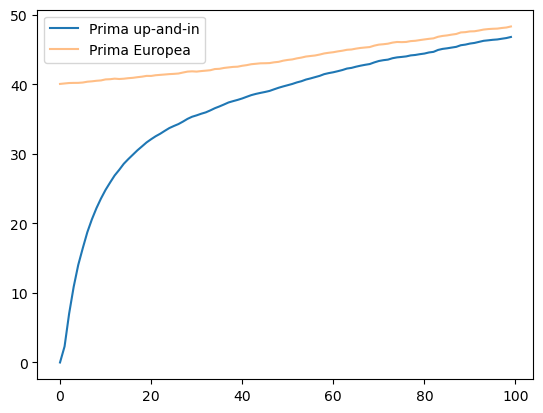

In [40]:
# Definir barrera
B = 200
# Crear función indicadora
I = (sim_closes > B).cumsum(axis=0) > 0
# Definir strike
strike = K
# Calcular la prima de una opción Europea
call = pd.DataFrame({'Prima Europea':
                     np.exp(-r*T)*np.fmax(sim_closes - strike, 0)
                     .mean(axis=1)})
# Calcular la prima de una opción barrera
callui = pd.DataFrame({'Prima up-and-in':
                       np.exp(-r*T)*(I * np.fmax(sim_closes - strike, 0))
                       .mean(axis=1)})
# Graficar el resultado de las dos primas previamente valuadas
ax = callui.plot();
call.plot(ax=ax, alpha=0.5);

In [41]:
call.iloc[-1]

Prima Europea    48.299055
Name: 99, dtype: float64

In [42]:
confianza = 0.99
sigma_est = sim_closes.iloc[-1].sem()
mean_est = call.iloc[-1]['Prima Europea']
i1 = st.t.interval(confianza, NbTraj - 1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i1)
print(i2)

(46.93434390712999, 49.6637663026932)
(46.93460441598907, 49.66350579383412)


In [44]:
callui.iloc[-1]

Prima up-and-in    46.791505
Name: 99, dtype: float64

In [45]:
confianza = 0.99
sigma_est = sim_closes.iloc[-1].sem()
mean_est = callui.iloc[-1]['Prima up-and-in']
i1 = st.t.interval(confianza, NbTraj - 1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i1)
print(i2)

(45.426794168013714, 48.15621656357692)
(45.42705467687279, 48.15595605471784)


# Ejercicio
Realizar la valuación de las opciones barrera para las acciones de Microsoft, siguiendo los siguientes lineamientos:
1. Realizar la valuación para el tipo de opción barrera 'CALL'- down-and-out, usando la suposición de rendimientos normales y usando el método del histograma. Para ambas valuaciones, comparar los resultados de la evaluación obtenida con los resultados obtenidos por la valuación Europea. Como se realizó en clase.
2. Repetir el inciso anterior pero en esta ocasión para el caso de 'PUT'- Up-and-out.

**Nota:** Analice los datos descargados y según el método ya sea `down-and-out` o `Up-and-out` defina un strike price usando la volatility smile vista en la clase de opciones europeas y basado en el spot price y el strike defina una barrera adecuada.

Se habilitará un enlace en canvas para subir un cuaderno de python, con la solución.

**Criterio de revisión.**

> Se te calificará de acuerdo a los resultados finales que reportes, basados en tu análisis.

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Oscar David Jaramillo Z.
</footer>